# Distribution of True Stellar Rotational Velocities

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

import scipy.stats as stats

Where the variable $x \equiv v$ is the true rotational velocity, and $y \equiv v \sin i$ is the projected rotational velocity. The variable $x$ follows a distribution $f_X(x)$, and the variable $y$ follows a distribution $f_Y(y)$. The parameter $\alpha$ is a constant that depends on the specific characteristics of the system being modeled.

The function designed in this proyect is

$$f_Y(y) = \int_y^\infty \frac{y^{2\alpha+1}}{x^{2\alpha+1}} \frac{1}{\sqrt{x^2 + y^2}} f_X(x) \, dx$$

In [3]:
# Load the datasets
gendata = pd.read_csv('data/geneve.dat', header=None)
gendata.columns = ['vsini']

In [4]:
gendata.describe()

,vsini
count,11818.000000
mean,7.725503
std,6.391010
min,0.000000
25%,3.000000
50%,6.000000
75%,10.000000
max,29.000000


In [5]:
gendata.min(), gendata.max()

(vsini    0
 dtype: int64,
 vsini    29
 dtype: int64)

By expert knowledge, we know that any star has a rotational velocity $v \leq 0$ km/s. Therefore, we have to remove the values where this condition is met.

In [7]:
print("Gendata vsini <= 0 count:",gendata[gendata.vsini <=0].vsini.count())
gendata = gendata[gendata.vsini > 0]

Gendata vsini <= 0 count: 133


First we will create the Kernel Density Estimation (KDE) function for the given $v \sin{i}$ data points, that represents the projected rotational velocities of stars. The KDE function will help us estimate the probability density function of the data $f_Y(y)$.

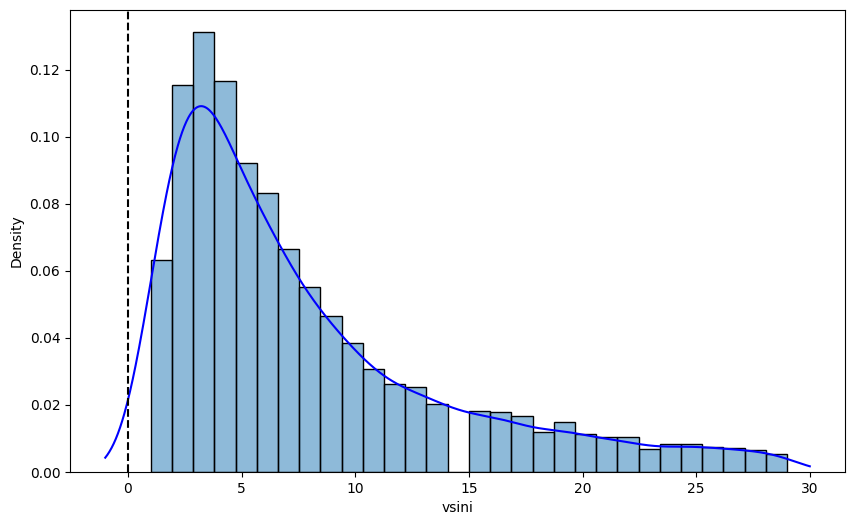

In [11]:
kde = stats.gaussian_kde(gendata.vsini, bw_method='silverman')
vsinimax, vsinimin = gendata.vsini.max(), gendata.vsini.min()
vsinirange = np.linspace(vsinimin-2, vsinimax+1, 1000)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(vsinirange, kde(vsinirange), label='Gendata KDE', color='blue')
sns.histplot(gendata.vsini, bins=30, stat='density', alpha=0.5, label='Gendata Histogram', ax=ax)
ax.axvline(0.0, color='black', linestyle='--')

As we can see in the KDE plot below, the projected rotational velocities are distributed between $0$ km/s and approximately $30$ km/s, with a peak around $3$ km/s. But the KDE does not begins exactly at $0$ km/s, so we will use a technique called "reflection" to ensure that the KDE starts at $0$ km/s. This technique involves reflecting the data points around the boundary (0 km/s in this case) to create a symmetric distribution.

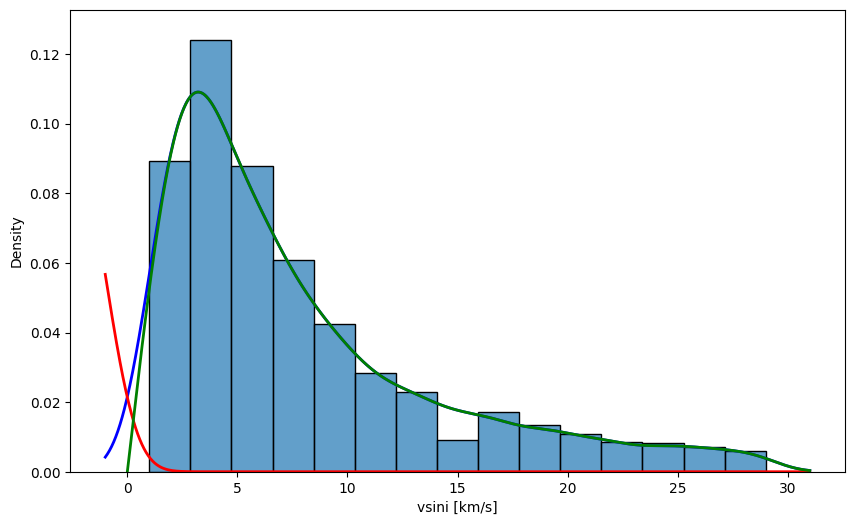

In [10]:
kdeplus = stats.gaussian_kde(dataset=gendata.vsini,bw_method='silverman')
kdenegs = stats.gaussian_kde(dataset=-gendata.vsini,bw_method='silverman')

vsinimax, vsinimin = max(gendata.vsini)+2, min(gendata.vsini-2)
vsinirange = np.linspace(start=vsinimin, stop=vsinimax, num=1000)
kdeplus_values = kdeplus.evaluate(vsinirange)
kdenegs_values = kdenegs.evaluate(vsinirange)
kde = kdeplus_values - kdenegs_values

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(vsinirange,kdeplus_values,color='blue',lw=2,label='KDE (Silverman)')
ax.plot(vsinirange,kdenegs_values,color='red',lw=2,label='KDE (Silverman)')
ax.plot(vsinirange,kde,color='green',lw=2,label='KDE Difference')
sns.histplot(
    data=gendata,
    x='vsini',
    bins=15,
    stat='density',
    edgecolor='black',
    alpha=0.7,
    ax=ax
)
ax.set_ylabel('Density')
ax.set_xlabel('vsini [km/s]')
plt.ylim(0, None)
plt.show()

Now we will create a meshgrid for the variables $x$ and $y$. The meshgrid will allow us to evaluate the integral for a range of values of $x$ and $y$.

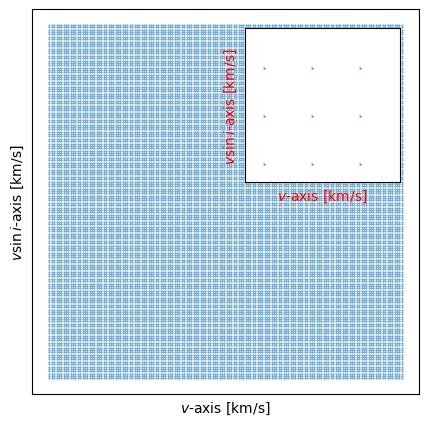

In [12]:
N = 150
a, b = 0.1, gendata.vsini.max()+5
dxx = (b - a)/N
dyy = (b - a + dxx/2)/N
xx = a + dxx * (np.arange(N)-0.05)
yy = a + dyy * (np.arange(N)-0.05)

meshx, meshy = np.meshgrid(xx, yy)

fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(meshx, meshy, s=1, marker='.', alpha=0.7)
ax.axis('equal')
ax.set_xlabel(r'$v$-axis [km/s]')
ax.set_ylabel(r'$v\sin{i}$-axis [km/s]')
ax.set_xticks([])
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xticklabels([])
axins = ax.inset_axes([0.55, 0.55, 0.4, 0.4], xlim=(0, dxx+0.5), ylim=(0, dyy+0.5))
axins.scatter(meshx, meshy, s=1, marker='.')
axins.set_xlabel(r'$v$-axis [km/s]',color='red')
axins.set_ylabel(r'$v\sin{i}$-axis [km/s]', color='red')
axins.set_yticklabels([])
axins.set_xticklabels([])
axins.set_xticks([])
axins.set_yticks([])
plt.show()

Recall the objective equation:
$$f_Y(y) = c_\alpha\int_y^\infty \frac{y^{2\alpha+1}}{x^{2\alpha+1}} \frac{1}{\sqrt{x^2 - y^2}} f_X(x) \, dx$$

We caan use a matrix form to represent the integral equation. We will discretize the integral by evaluating it at the meshgrid points.

$$\underbrace{f_Y(y)}_{\mathbf{Y}} = \underbrace{c_\alpha\int_y^\infty dx \frac{y^{2\alpha+1}}{x^{2\alpha+1}} \frac{1}{\sqrt{x^2 - y^2}}}_{\mathbf{A}}  \, \underbrace{f_X(x)}_{\mathbf{X}} $$

Now we will using the matrix form for our objetive equation: 
$$Y = AX$$

where $Y = f_Y(y)$, $X = f_X(x)$, and $A$ is the matrix that contains the values of the integrand evaluated at the meshgrid points.

Now we will solve for $X$ using the pseudo-inverse of matrix $A$:
$$X = A^{-1}Y$$

First we will create the A matrix by evaluating the integrand at the meshgrid points. Then we will compute the pseudo-inverse of matrix $A$ using the Singular Value Decomposition (SVD) method. So we also create a vector of $\alpha$ values to evaluate the integrand for different $\alpha$ values.

Finally, we will multiply the pseudo-inverse of matrix $A$ with the KDE values $Y$ to obtain the estimated distribution of true stellar rotational velocities $X = f_X(x)$.

In [13]:
alphas = np.linspace(-0.5, 2.0, 10)
A = np.zeros((len(alphas),N,N))
for i, alpha in enumerate(alphas):
    for j in range(N):
        for k in range(N):
            v = xx[j]
            vsini = yy[k]
            if vsini <= v:
                A[i,j,k] = (vsini/v)**(2*alpha+1)*1/np.sqrt(v**2 - vsini**2)
            else:
                A[i,j,k] = 0.0